In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.metrics import f1_score
import os 
import lightgbm as lgb
import gc

# Prep stage 

In [2]:
model_name = 'model_21'
MainPth = 'C:/Users/denis/Machine_Learning_Competitions/indian_hack/'
ModelFolder = MainPth + model_name + '/'

In [3]:
def check_empy(pth):
    if ( os.path.exists(pth) ):
        if (len(os.listdir(pth)) > 0):
            raise Exception('Folder is not empy!')
        else:
            pass

In [4]:
train_pth = ModelFolder + '/train/'
test_pth = ModelFolder + '/test/'

scores = []

# check if files in folder - no re-writing is good 
check_empy(train_pth)
check_empy(test_pth)

# create folder if it does not exist 
if not os.path.exists(train_pth):
    os.makedirs(train_pth)
    
if not os.path.exists(test_pth):
    os.makedirs(test_pth)

# Read data 

In [5]:
data_pth = MainPth + 'data/'

In [6]:
train = pd.read_csv(data_pth + 'train.csv')
train = train.sort_values(by='DateTime').reset_index(drop=True)

test = pd.read_csv(data_pth + 'test.csv')
ssub = pd.read_csv(data_pth + 'sample_submission.csv')
history = pd.read_csv(data_pth + 'historical_user_logs.csv')

train['session_id'] = np.arange(len(train))
test['session_id'] = np.arange(len(test)) + len(train)

In [7]:
np.min(train['DateTime']), np.min(test['DateTime']), np.min(history['DateTime'])

('2017-07-02 00:00', '2017-07-08 00:00', '2017-05-28 15:44')

In [8]:
np.max(train['DateTime']), np.max(test['DateTime']), np.max(history['DateTime'])

('2017-07-07 23:59', '2017-07-09 21:29', '2017-07-01 23:59')

In [9]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


# history

In [10]:
history['action'] = (history['action']=='interest')*1
history['DateTime'] = pd.to_datetime(history['DateTime'])

In [11]:
history.head()

,DateTime,user_id,product,action
0,2017-05-28 15:44:00,704,B,0
1,2017-05-29 07:08:00,499679,F,0
2,2017-05-29 07:10:00,499679,G,0
3,2017-05-29 07:10:00,499679,G,0
4,2017-05-29 07:10:00,499679,G,0


In [12]:
def get_h_str(x):
    x = [str(x) for x in x]
    return ' '.join(x)
hist_texts = history[['user_id','product']].groupby('user_id').agg(get_h_str).reset_index()
hist_texts = hist_texts.rename({'product':'hist_texts'},axis=1)

In [13]:
print(history.shape)
history = history.drop_duplicates(subset=['DateTime','user_id'])
print(history.shape)

(24287534, 4)
(10692974, 4)


In [14]:
%%time
def diff(x):
    d = np.diff(x)
    return list(d)

t = history[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

Wall time: 10.3 s


In [15]:
t = history[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions

100%|████████████████████████████████████████████████████████████████████████| 171309/171309 [00:20<00:00, 8548.83it/s]


In [16]:
history = history.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
history['h_time_since_last_add'] = diffs
history['h_time_sessions_id'] = time_sessions_id

In [17]:
history['day_DateTime'] = history['DateTime'].dt.day

In [18]:
temp = history[['user_id','h_time_sessions_id']].groupby('user_id').agg('max').reset_index()
temp = temp.rename({'h_time_sessions_id':'max_hist_ses'}, axis=1)
train = pd.merge(train, temp, how='left', on='user_id')
test = pd.merge(test, temp, how='left', on='user_id')

In [19]:
def ret_set(x):
    return len(set(x))

temp = history[['user_id','day_DateTime']].groupby('user_id').agg(ret_set).reset_index()
temp = temp.rename({'day_DateTime':'hist_num_active_days'}, axis=1)
train = pd.merge(train, temp, how='left', on='user_id')
test = pd.merge(test, temp, how='left', on='user_id')

In [20]:
train['max_hist_ses'] = train['max_hist_ses'].fillna(0)
test['max_hist_ses'] = test['max_hist_ses'].fillna(0)
train['hist_num_active_days'] = train['hist_num_active_days'].fillna(-1)
test['hist_num_active_days'] = test['hist_num_active_days'].fillna(-1)

train['ses_per_day_hist'] = train['max_hist_ses'] / train['hist_num_active_days']
test['ses_per_day_hist'] = test['max_hist_ses'] / test['hist_num_active_days']

In [21]:
train.shape, test.shape

((463291, 18), (128858, 17))

In [22]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,max_hist_ses,hist_num_active_days,ses_per_day_hist
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,13.0,9.0,1.444444
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,9.0,6.0,1.500000
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,9.0,6.0,1.500000
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,11.0,8.0,1.375000
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,6.0,4.0,1.500000


# hist 

In [23]:
history = pd.read_csv(data_pth + 'historical_user_logs.csv')
history['action'] = (history['action']=='interest')*1
history['DateTime'] = pd.to_datetime(history['DateTime'])

In [24]:
t = history[['user_id','action']].groupby('user_id').agg('mean').reset_index()
t = t.rename({'action':'action_mean'},axis=1)
train = pd.merge(train, t, how='left', on='user_id')
test = pd.merge(test, t, how='left', on='user_id')
train['action_mean'] = train['action_mean'].fillna(-1)
test['action_mean'] = test['action_mean'].fillna(-1)

t = history[['user_id','action']].groupby('user_id').agg('count').reset_index()
t = t.rename({'action':'action_count'},axis=1)
train = pd.merge(train, t, how='left', on='user_id')
test = pd.merge(test, t, how='left', on='user_id')
train['action_count'] = train['action_count'].fillna(0)
test['action_count'] = test['action_count'].fillna(0)

t = history[['user_id','action','product']].groupby(['user_id','product']).agg('mean').reset_index()
t = t.rename({'action':'actionlproduct_mean'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','product'])
test = pd.merge(test, t, how='left', on=['user_id','product'])
train['actionlproduct_mean'] = train['actionlproduct_mean'].fillna(-1)
test['actionlproduct_mean'] = test['actionlproduct_mean'].fillna(-1)

t = history[['user_id','action','product']].groupby(['user_id','product']).agg('count').reset_index()
t = t.rename({'action':'actionlproduct_count'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','product'])
test = pd.merge(test, t, how='left', on=['user_id','product'])
train['actionlproduct_count'] = train['actionlproduct_count'].fillna(0)
test['actionlproduct_count'] = test['actionlproduct_count'].fillna(0)

In [25]:
train.shape, test.shape

((463291, 22), (128858, 21))

In [26]:
# t_piv = t.pivot(columns='product',values='actionlproduct_mean',index='user_id').reset_index()

In [27]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,city_development_index,var_1,is_click,max_hist_ses,hist_num_active_days,ses_per_day_hist,action_mean,action_count,actionlproduct_mean,actionlproduct_count
0,0,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,...,3.0,0,0,13.0,9.0,1.444444,0.000000,627.0,0.000000,5.0
1,1,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,...,NaN,0,0,9.0,6.0,1.500000,0.000000,62.0,0.000000,11.0
2,2,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,...,NaN,0,0,9.0,6.0,1.500000,0.000000,62.0,0.000000,11.0
3,3,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,...,2.0,1,0,11.0,8.0,1.375000,0.046512,43.0,0.111111,9.0
4,4,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,...,2.0,1,0,6.0,4.0,1.500000,0.050000,60.0,0.000000,3.0


# Time since last add 

In [28]:
train.shape, test.shape

((463291, 22), (128858, 21))

In [29]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

# left -> right

In [30]:
def diff(x):
    d = np.diff(x)
    return list(d)

In [31]:
all_data = pd.concat([train.drop('is_click',axis=1),test],axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='DateTime').reset_index(drop=True)
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data = all_data[['user_id','DateTime']].drop_duplicates().reset_index(drop=True)
all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data.shape

(479746, 2)

In [32]:
t = all_data[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions
    
print(len(ids), len(diffs), len(time_sessions_id))

all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data['time_since_last_add'] = diffs
all_data['time_sessions_id'] = time_sessions_id

100%|███████████████████████████████████████████████████████████████████████| 177729/177729 [00:11<00:00, 15416.15it/s]


479746 479746 479746


In [33]:
# get number of page to the end of current session
def n_page(x):
    t = np.arange(len(x))
    return [len(x) - t - 1 for t in t]

t = all_data[['user_id','time_sessions_id','DateTime']].groupby(['user_id','time_sessions_id']).agg(n_page).reset_index()

ids = []
time_sessions_id = []
n_page = []

for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = list(time_array)
    ids += [t['user_id'][i]] * len(a)
    time_sessions_id += [t['time_sessions_id'][i]] * len(a)
    n_page += a
    
print(len(ids), len(time_sessions_id), len(n_page))

all_data = all_data.sort_values(by=['user_id','time_sessions_id']).reset_index(drop=True)
all_data['n_page_in_session'] = n_page

100%|███████████████████████████████████████████████████████████████████████| 405021/405021 [00:32<00:00, 12512.46it/s]


479746 479746 479746


In [34]:
all_data.head()

,user_id,DateTime,time_since_last_add,time_sessions_id,n_page_in_session
0,4,2017-07-02 14:51:00,-1.0,0,0
1,4,2017-07-09 11:07:00,9856.0,1,0
2,6,2017-07-06 12:33:00,-1.0,0,0
3,19,2017-07-02 15:25:00,-1.0,0,0
4,19,2017-07-05 09:22:00,3957.0,1,0


In [35]:
# number of sessions 
t = all_data[['user_id','time_sessions_id']].groupby('user_id').agg('max').reset_index()
t = t.rename({'time_sessions_id':'max_number_sessions'},axis=1)
all_data = pd.merge(all_data, t, how='left', on='user_id')

# number of pages in session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_pages_this_session'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

# mean of time per session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('mean').reset_index()
t = t.rename({'time_since_last_add':'mean_time_ses'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

# std of time per session
t = all_data[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('std').reset_index()
t = t.rename({'time_since_last_add':'std_time_ses'},axis=1)
all_data = pd.merge(all_data, t, how='left', on=['user_id','time_sessions_id'])

In [36]:
all_data['DateTime'] = all_data['DateTime'].astype('str')
train['DateTime'] = train['DateTime'].astype('str')
test['DateTime'] = test['DateTime'].astype('str')

In [37]:
train = pd.merge(train, all_data, how='left', on=['user_id','DateTime'])
test = pd.merge(test, all_data, how='left', on=['user_id','DateTime'])

### number of ads per ses

In [38]:
t = train[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_ads_ses'},axis=1)
train = pd.merge(train, t, how='left', on=['user_id','time_sessions_id'])

t = test[['user_id','time_sessions_id','time_since_last_add']].groupby(['user_id','time_sessions_id']).agg('count').reset_index()
t = t.rename({'time_since_last_add':'num_ads_ses'},axis=1)
test = pd.merge(test, t, how='left', on=['user_id','time_sessions_id'])

### stats on session length 

In [39]:
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
t = all_data[['user_id', 'time_sessions_id','DateTime']].groupby(['user_id','time_sessions_id']).agg(lambda x: np.max(x)-np.min(x))
t = t.reset_index()
t['DateTime'] = t['DateTime'].dt.seconds

for a in tqdm(['mean', 'max', 'min', 'std', 'sum']):
    temp = t[['user_id','DateTime']].groupby(['user_id']).agg(a).reset_index()
    temp = temp.rename({'DateTime':'ses_time_'+a},axis=1)
    train = pd.merge(train, temp, how='left', on='user_id')
    test = pd.merge(test, temp, how='left', on='user_id')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.60it/s]


In [40]:
# drop session info 
train = train.drop('time_sessions_id',axis=1)
test = test.drop('time_sessions_id',axis=1)

In [41]:
train['std_time_ses'] = train['std_time_ses'].fillna(0)
test['std_time_ses'] = test['std_time_ses'].fillna(0)

# right -> left 

In [42]:
def diff(x):
    x = x[::-1]
    d = np.diff(x)
    return list(d)

In [43]:
all_data = pd.concat([train.drop('is_click',axis=1),test],axis=0).reset_index(drop=True)
all_data = all_data.sort_values(by='DateTime').reset_index(drop=True)
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data = all_data[['user_id','DateTime']].drop_duplicates().reset_index(drop=True)
all_data = all_data.sort_values(by=['user_id','DateTime']).reset_index(drop=True)
all_data.shape

(479746, 2)

In [44]:
t = all_data[['user_id','DateTime']].groupby('user_id').agg(diff).reset_index()

ids = []
diffs = []
time_sessions_id = []
for i in tqdm(range(len(t))):
    time_array = t['DateTime'][i]
    a = [-1] + [x.item() / 1e9 / 60 for x in time_array]
    diffs += a
    ids += [t['user_id'][i]] * len(a)
    
    sessions = [0]
    if len(a)!=1:
        s = 0
        for j in range(1, len(a)):
            if a[j] > 30: # 30 min diff between pages 
                s += 1
            sessions.append(s)
    time_sessions_id += sessions

100%|███████████████████████████████████████████████████████████████████████| 177729/177729 [00:11<00:00, 15854.35it/s]


In [45]:
all_data = all_data.sort_values(by=['user_id','DateTime'], ascending=[True, False]).reset_index(drop=True)
all_data['reversed_time_since_last_add'] = diffs

all_data['DateTime'] = all_data['DateTime'].astype('str')
train['DateTime'] = train['DateTime'].astype('str')
test['DateTime'] = test['DateTime'].astype('str')

train = pd.merge(train, all_data, how='left', on=['user_id','DateTime'])
test = pd.merge(test, all_data, how='left', on=['user_id','DateTime'])

In [46]:
all_data.head(10)

,user_id,DateTime,reversed_time_since_last_add
0,4,2017-07-09 11:07:00,-1.0
1,4,2017-07-02 14:51:00,-9856.0
2,6,2017-07-06 12:33:00,-1.0
3,19,2017-07-09 15:22:00,-1.0
4,19,2017-07-05 09:22:00,-6120.0
5,19,2017-07-02 15:25:00,-3957.0
6,25,2017-07-03 20:14:00,-1.0
7,26,2017-07-06 20:00:00,-1.0
8,30,2017-07-02 10:18:00,-1.0
9,33,2017-07-07 10:14:00,-1.0


In [47]:
train.shape, test.shape

((463291, 35), (128858, 34))

In [48]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,num_pages_this_session,mean_time_ses,std_time_ses,num_ads_ses,ses_time_mean,ses_time_max,ses_time_min,ses_time_std,ses_time_sum,reversed_time_since_last_add
0,0,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,...,1,-1.0,0.00000,1,0.0,0,0,0.000000,0,-7089.0
1,1,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,...,2,0.5,2.12132,3,300.0,480,120,254.558441,600,-2.0
2,2,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,...,2,0.5,2.12132,3,300.0,480,120,254.558441,600,-2.0
3,3,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,...,1,-1.0,0.00000,1,60.0,480,0,149.398795,660,-2589.0
4,4,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,...,1,-1.0,0.00000,1,60.0,180,0,103.923048,180,-6675.0


# number of ads on same page 

In [49]:
temp = train[['DateTime','user_id','session_id']].groupby(['DateTime','user_id']).agg('count').reset_index()
temp = temp.rename({'session_id':'number_ads_page'},axis=1)
train = pd.merge(train, temp, how='left', on=['DateTime','user_id'])

temp = test[['DateTime','user_id','session_id']].groupby(['DateTime','user_id']).agg('count').reset_index()
temp = temp.rename({'session_id':'number_ads_page'},axis=1)
test = pd.merge(test, temp, how='left', on=['DateTime','user_id'])

In [50]:
history.head()

,DateTime,user_id,product,action
0,2017-05-28 15:44:00,704,B,0
1,2017-05-29 07:08:00,499679,F,0
2,2017-05-29 07:10:00,499679,G,0
3,2017-05-29 07:10:00,499679,G,0
4,2017-05-29 07:10:00,499679,G,0


# Datetime features 

In [51]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

In [52]:
train['dt_hour'] = train['DateTime'].dt.hour
#train['dt_weekday'] = train['DateTime'].dt.dayofweek
train['dt_minsince2400'] = train['DateTime'].dt.hour * 60 + train['DateTime'].dt.minute

test['dt_hour'] = test['DateTime'].dt.hour
#test['dt_weekday'] = test['DateTime'].dt.dayofweek
test['dt_minsince2400'] = test['DateTime'].dt.hour * 60 + test['DateTime'].dt.minute

In [53]:
# train = train.sort_values(by='DateTime').reset_index(drop=True)

# additional cat cols 

In [54]:
cat_cols = ['user_id','product','campaign_id','webpage_id','product_category_1','product_category_2',
           'user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']

In [55]:
user_cat = ['user_id','user_group_id', 'gender', 'age_level', 'user_depth', 'city_development_index', 'var_1']
add_cat = ['product','campaign_id','webpage_id','product_category_1','product_category_2']


print('len cat cols:', len(cat_cols))
for c1 in user_cat:
    train[c1] = train[c1].astype('str')
    test[c1] = test[c1].astype('str')
    for c2 in add_cat:
        train[c2] = train[c2].astype('str')
        test[c2] = test[c2].astype('str')
        
        train[c1+'_and_'+c2] = train[c1].astype('str') + '_and_' + train[c2].astype('str')
        test[c1+'_and_'+c2] = test[c1].astype('str') + '_and_' + test[c2].astype('str')
        cat_cols.append(c1+'_and_'+c2)
print('len cat cols:', len(cat_cols))

len cat cols: 12
len cat cols: 47


In [56]:
print('len cat cols:', len(cat_cols))
for i1 in range(len(add_cat)-1):
    for i2 in range(i1+1, len(add_cat)):
        c1 = add_cat[i1]
        c2 = add_cat[i2]
        
        train[c1+'_and_'+c2] = train[c1].astype('str') + '_and_' + train[c2].astype('str')
        test[c1+'_and_'+c2] = test[c1].astype('str') + '_and_' + test[c2].astype('str')
        cat_cols.append(c1+'_and_'+c2)
print('len cat cols:', len(cat_cols))

len cat cols: 47
len cat cols: 57


### add stats 

In [57]:
def len_set(x):
    return len(set(x))

def frac_set(x):
    return len(set(x)) / len(x)

In [62]:
X = pd.concat([train[['user_id']+add_cat], test[['user_id']+add_cat]], axis=0).reset_index(drop=True)
for cc in add_cat:
    temp = X[['user_id',cc]].groupby(cc).agg('count').reset_index()
    temp = temp.rename({'user_id':'counts_'+cc},axis=1)
    train = pd.merge(train, temp, how='left', on=cc)
    test = pd.merge(test, temp, how='left', on=cc)
    
    temp = X[['user_id',cc]].groupby(cc).agg(len_set).reset_index()
    temp = temp.rename({'user_id':'lenSet_'+cc},axis=1)
    train = pd.merge(train, temp, how='left', on=cc)
    test = pd.merge(test, temp, how='left', on=cc)
    
    temp = X[['user_id',cc]].groupby(cc).agg(frac_set).reset_index()
    temp = temp.rename({'user_id':'fracSet_'+cc},axis=1)
    train = pd.merge(train, temp, how='left', on=cc)
    test = pd.merge(test, temp, how='left', on=cc)

In [63]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,fracSet_campaign_id,counts_webpage_id,lenSet_webpage_id,fracSet_webpage_id,counts_product_category_1,lenSet_product_category_1,fracSet_product_category_1,counts_product_category_2,lenSet_product_category_2,fracSet_product_category_2
0,0,2017-07-02 00:00:00,858557,C,359520,13787,4,nan,10.0,Female,...,0.431009,188568,70355,0.373101,165055,75472,0.457254,442025,150743,0.341028
1,1,2017-07-02 00:00:00,243253,C,105960,11085,5,nan,8.0,Female,...,0.467694,40349,18871,0.467694,109782,59153,0.538822,442025,150743,0.341028
2,2,2017-07-02 00:00:00,243253,C,359520,13787,4,nan,8.0,Female,...,0.431009,188568,70355,0.373101,165055,75472,0.457254,442025,150743,0.341028
3,3,2017-07-02 00:00:00,1097446,I,359520,13787,3,nan,3.0,Male,...,0.431009,188568,70355,0.373101,133315,77215,0.579192,442025,150743,0.341028
4,4,2017-07-02 00:01:00,663656,C,405490,60305,3,nan,2.0,Male,...,0.577757,107919,62351,0.577757,133315,77215,0.579192,442025,150743,0.341028


# Counters of user's demograpics 

def rel_len_set(x):
    return len(set(list(x)))

c = 'user_group_id'
t = all_data[['user_id','product']].groupby('product').agg(['count',rel_len_set]).reset_index()

# Prep X_train, X_test

In [64]:
X_train = train.drop(['DateTime','session_id'], axis=1)
X_test = test.drop(['DateTime','session_id'], axis=1)
y_train = train['is_click']

In [65]:
for cc in tqdm(cat_cols):
    
    fillna_const = 'MISSING_VALUE'
    
    X_train[cc] = X_train[cc].astype('str').fillna(fillna_const)
    X_test[cc] = X_test[cc].astype('str').fillna(fillna_const)
    
    X_train[cc] = X_train[cc].astype('category')
    X_test[cc] = X_test[cc].astype('category')

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:42<00:00,  1.33it/s]


# TFIDF

In [66]:
from scipy.sparse import csr_matrix

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))

In [68]:
tf_cols = ['product','campaign_id','webpage_id','product_category_1','product_category_2']

X = pd.concat([X_train[['user_id']+tf_cols], X_test[['user_id']+tf_cols]], axis=0).reset_index(drop=True)
print('X formed', X.shape)

X formed (592149, 6)


In [69]:
X.head()

,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2
0,858557,C,359520,13787,4,nan
1,243253,C,105960,11085,5,nan
2,243253,C,359520,13787,4,nan
3,1097446,I,359520,13787,3,nan
4,663656,C,405490,60305,3,nan


In [70]:
for cc in tf_cols:
    temp = X[['user_id', cc]].groupby(['user_id']).agg(lambda x: ' '.join(x)).reset_index()
    X_trfd = tf.fit_transform(temp[cc])
    X_trfd = pd.DataFrame(X_trfd.todense(), columns = ['tfidf_'+cc+'_'+str(x) for x in tf.vocabulary_.values()])
    temp = temp.drop(cc,axis=1)
    temp = pd.concat([temp, X_trfd], axis=1)
    
    print(cc, X_trfd.shape)

    X_train = pd.merge(X_train, temp, how='left', on='user_id')
    X_test = pd.merge(X_test, temp, how='left', on='user_id')

product (177729, 10)
campaign_id (177729, 10)
webpage_id (177729, 9)
product_category_1 (177729, 5)
product_category_2 (177729, 32)


In [76]:
hist_texts

,user_id,tfidf_hist_texts_5,tfidf_hist_texts_1,tfidf_hist_texts_4,tfidf_hist_texts_6,tfidf_hist_texts_9,tfidf_hist_texts_0,tfidf_hist_texts_2,tfidf_hist_texts_8,tfidf_hist_texts_7,tfidf_hist_texts_3
0,4,0.796805,0.221522,0.000000,0.000000,0.000000,0.000000,0.000000,0.208709,0.521987,0.000000
1,19,0.192500,0.240830,0.013436,0.698293,0.148685,0.536918,0.277267,0.172876,0.000000,0.000000
2,25,0.173151,0.000000,0.000000,0.000000,0.029256,0.046953,0.964777,0.170078,0.085074,0.000000
3,26,0.000000,0.777990,0.000000,0.000000,0.000000,0.000000,0.000000,0.628277,0.000000,0.000000
4,30,0.063698,0.212506,0.435697,0.061036,0.258297,0.000000,0.033802,0.800858,0.219074,0.000000
5,33,0.198441,0.195600,0.511209,0.293863,0.000000,0.039135,0.172315,0.680441,0.283633,0.000000
6,37,0.477133,0.271328,0.127154,0.436410,0.000000,0.352866,0.000000,0.409015,0.447543,0.000000
7,46,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,51,0.209540,0.489341,0.286653,0.642502,0.169938,0.000000,0.355818,0.197587,0.164723,0.000000
9,62,0.504854,0.011081,0.220695,0.280067,0.000000,0.014411,0.014100,0.772546,0.143606,0.000000


In [75]:
X_trfd = tf.fit_transform(hist_texts['hist_texts'])
X_trfd = pd.DataFrame(X_trfd.todense(), columns = ['tfidf_hist_texts_'+str(x) for x in tf.vocabulary_.values()])
hist_texts = hist_texts.drop('hist_texts',axis=1)
hist_texts = pd.concat([hist_texts, X_trfd], axis=1)
hist_texts['user_id'] = hist_texts['user_id'].astype('str')
    
print(cc, X_trfd.shape)

X_train = pd.merge(X_train, hist_texts, how='left', on='user_id')
X_test = pd.merge(X_test, hist_texts, how='left', on='user_id')

KeyError: 'hist_texts'

product_category_2 (171309, 10)


In [78]:
X_train.shape, X_test.shape

((463291, 172), (128858, 171))

In [79]:
X_train.head()

,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,...,tfidf_hist_texts_5,tfidf_hist_texts_1,tfidf_hist_texts_4,tfidf_hist_texts_6,tfidf_hist_texts_9,tfidf_hist_texts_0,tfidf_hist_texts_2,tfidf_hist_texts_8,tfidf_hist_texts_7,tfidf_hist_texts_3
0,858557,C,359520,13787,4,nan,10.0,Female,4.0,3.0,...,0.000000,0.112021,0.008203,0.040218,0.989423,0.072842,0.017818,0.032982,0.009899,0.0
1,243253,C,105960,11085,5,nan,8.0,Female,2.0,2.0,...,0.000000,0.319086,0.342685,0.000000,0.000000,0.103744,0.033836,0.876837,0.000000,0.0
2,243253,C,359520,13787,4,nan,8.0,Female,2.0,2.0,...,0.000000,0.319086,0.342685,0.000000,0.000000,0.103744,0.033836,0.876837,0.000000,0.0
3,1097446,I,359520,13787,3,nan,3.0,Male,3.0,3.0,...,0.000000,0.376173,0.275450,0.054022,0.000000,0.000000,0.299173,0.664527,0.498600,0.0
4,663656,C,405490,60305,3,nan,2.0,Male,2.0,3.0,...,0.820525,0.370690,0.100222,0.000000,0.000000,0.111251,0.000000,0.402979,0.067191,0.0


# Lgb

In [80]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

loss_function_name = 'auc'

kf = KFold(n_splits=10)
kf_lr = StratifiedKFold(n_splits=5, shuffle=True, random_state=424242)

In [81]:
def check_empy(pth):
    if ( os.path.exists(pth) ):
        if (len(os.listdir(pth)) > 0):
            raise Exception('Folder is not empy!')
        else:
            pass

In [82]:
params = {
    'objective':'binary', 
    'metric': 'AUC',
    'learning_rate': 0.01, 
    'random_state': 4242442,
    'verbose_eval': 0,
    'class_weight': 'balanced'
}
            
params['num_leaves'] = 145
params['min_data_in_leaf'] = 15
params['feature_fraction'] = 0.2244
params['bagging_fraction'] = 0.8713
params['subsample'] = 0.465
params['colsample_bytree'] = 0.0856
params['min_child_weight'] = 13
params['min_child_samples'] = 22
params['reg_lambda'] = 1
params['reg_alpha'] = 55
params['subsample_freq'] = 3

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_predict

In [84]:
train_pth = ModelFolder + 'train/'
test_pth = ModelFolder + 'test/'

scores = []

# write basic info
log_file_name = ModelFolder + '_log_file.txt'
with open(log_file_name, 'a') as the_file:
    the_file.write('Train, test shapes\n')
    the_file.write(str(X_train.shape)+'\n')
    the_file.write(str(X_test.shape)+'\n')

for n_fold, (train_index, test_index) in tqdm(enumerate(kf.split(X_train, y_train))):
    
    # replace cat cols 
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True).copy()
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True).copy()
    X_test_temp = X_test.reset_index(drop=True).copy()
    
    y_train_temp = X_train_temp['is_click']
    X_train_temp = X_train_temp.drop('is_click', axis=1)
    y_val_temp = X_val_temp['is_click']
    X_val_temp = X_val_temp.drop('is_click', axis=1)
    
    for cc in tqdm(cat_cols):
        le = LabelEncoder()
        le.fit(list(set(X_test[cc]) | set(X_train[cc])))
        print(le.classes_)
        X_train_temp[[cc]] = le.transform(X_train_temp[[cc]])
        X_val_temp[[cc]] = le.transform(X_val_temp[[cc]])
        X_test_temp[[cc]] = le.transform(X_test_temp[[cc]])
    
        lr = LinearRegression(n_jobs=-1)
        ohe = OneHotEncoder(sparse=True)
        ohe.fit(np.arange(len(le.classes_)).reshape(-1, 1))
        x_ohe_train = ohe.transform(X_train_temp[[cc]])
        x_ohe_val = ohe.transform(X_val_temp[[cc]])
        x_ohe_test = ohe.transform(X_test_temp[[cc]])
        
        lr.fit(x_ohe_train, y_train_temp)
    
        X_train_temp[cc] = cross_val_predict(lr, x_ohe_train, y_train_temp, cv=kf_lr, n_jobs=-1)
        X_val_temp[cc] = lr.predict(x_ohe_val)
        X_test_temp[cc] = lr.predict(x_ohe_test)
    
    print(X_train_temp.shape)
    
    lgb_data_train = lgb.Dataset(X_train_temp, 
                                 label=y_train_temp,
                                 free_raw_data=False)

    lgb_data_valid = lgb.Dataset(X_val_temp, 
                                 label=y_val_temp,
                                 free_raw_data=False,
                                 reference=lgb_data_train)
    model = lgb.train(params, 
                      lgb_data_train, 
                      valid_sets = lgb_data_valid,
                      verbose_eval=200,
                      #feval = lgb_f1_score,
                      early_stopping_rounds=200,
                      num_boost_round=500000)
    
    y_hat_valid = model.predict(X_val_temp)
    y_hat_test = model.predict(X_test_temp)
    
    y_hat_valid = pd.DataFrame({'DF_index':test_index, 'pred':y_hat_valid})
    y_hat_test = pd.DataFrame(y_hat_test)
    
    
    # save predictions 
    y_hat_valid.to_csv(train_pth+'nfold'+str(n_fold)+'.csv',index=False)
    y_hat_test.to_csv(test_pth+'nfold'+str(n_fold)+'.csv',index=False)
    
    # calculate score 
    score_valid = scoring(y_train[test_index].values, y_hat_valid['pred'])
    
    with open(log_file_name, 'a') as the_file:
        the_file.write('Score for '+ str(n_fold)+ ' fold: '+ str(score_valid) + '\n')
        
    scores.append(score_valid)
    
with open(log_file_name, 'a') as the_file:
    the_file.write('---\n')
    the_file.write('Mean score ' + str(np.mean(scores)) + '+' + str(np.std(scores)))

0it [00:00, ?it/s]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:17<16:07, 17.28s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:27<12:31, 13.66s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:36<11:00, 12.23s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:45<10:03, 11.38s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:54<09:26, 10.90s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [01:06<09:22, 11.03s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [01:26<10:16, 12.33s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [01:36<09:50, 12.06s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [01:44<09:19, 11.65s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:54<08:58, 11.46s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [02:04<08:40, 11.31s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [02:13<08:21, 11.15s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [02:31<08:31, 11.62s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [02:45<08:29, 11.85s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [03:01<08:27, 12.09s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [03:15<08:20, 12.22s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [03:28<08:10, 12.27s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [03:40<07:58, 12.26s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [03:50<07:41, 12.13s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [04:00<07:25, 12.05s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [04:10<07:09, 11.92s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [04:26<07:03, 12.10s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [04:33<06:44, 11.89s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [04:41<06:26, 11.71s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [04:48<06:09, 11.55s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [04:56<05:53, 11.39s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [05:06<05:40, 11.36s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [05:17<05:28, 11.32s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [05:28<05:16, 11.32s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [05:38<05:04, 11.27s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [05:46<04:50, 11.18s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [05:59<04:41, 11.24s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [06:07<04:27, 11.13s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [06:16<04:14, 11.06s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [06:23<04:00, 10.95s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [06:30<03:47, 10.84s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [06:39<03:36, 10.81s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [06:47<03:23, 10.72s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [06:55<03:11, 10.65s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [07:02<02:59, 10.57s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [07:09<02:47, 10.49s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [07:21<02:37, 10.50s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [07:28<02:25, 10.43s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [07:35<02:14, 10.35s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [07:42<02:03, 10.29s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [07:52<01:52, 10.26s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [08:03<01:42, 10.28s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [08:17<01:33, 10.36s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [08:31<01:23, 10.45s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [08:44<01:13, 10.49s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [08:59<01:03, 10.59s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [09:09<00:52, 10.57s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [09:20<00:42, 10.58s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [09:33<00:31, 10.62s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [09:45<00:21, 10.64s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [09:58<00:10, 10.69s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [10:12<00:00, 10.74s/it]


(416961, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.630063
[400]	valid_0's auc: 0.640476
[600]	valid_0's auc: 0.648245
[800]	valid_0's auc: 0.653045
[1000]	valid_0's auc: 0.656051
[1200]	valid_0's auc: 0.657909
[1400]	valid_0's auc: 0.659536
[1600]	valid_0's auc: 0.660775
[1800]	valid_0's auc: 0.661554
[2000]	valid_0's auc: 0.662168
[2200]	valid_0's auc: 0.662729
[2400]	valid_0's auc: 0.663183
[2600]	valid_0's auc: 0.663482
[2800]	valid_0's auc: 0.663587
[3000]	valid_0's auc: 0.663799
[3200]	valid_0's auc: 0.663882
[3400]	valid_0's auc: 0.663997
[3600]	valid_0's auc: 0.664118
[3800]	valid_0's auc: 0.664311
[4000]	valid_0's auc: 0.664272
Early stopping, best iteration is:
[3908]	valid_0's auc: 0.66438


1it [32:42, 1962.44s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:17<16:09, 17.31s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:26<12:12, 13.32s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:35<10:42, 11.90s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:44<09:54, 11.21s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:54<09:21, 10.80s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [01:04<09:04, 10.68s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [01:13<08:45, 10.51s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [01:22<08:25, 10.32s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [01:31<08:08, 10.19s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:40<07:52, 10.05s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:49<07:37,  9.94s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:58<07:22,  9.84s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [02:18<07:47, 10.62s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [02:37<08:04, 11.28s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [02:59<08:21, 11.95s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [03:19<08:31, 12.47s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [03:39<08:36, 12.92s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [03:57<08:33, 13.17s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [04:12<08:24, 13.27s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [04:27<08:14, 13.35s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [04:40<08:00, 13.34s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [04:58<07:54, 13.56s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [05:08<07:36, 13.42s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [05:17<07:17, 13.25s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [05:27<06:59, 13.11s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [05:37<06:41, 12.97s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [05:49<06:28, 12.95s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [06:04<06:17, 13.01s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [06:17<06:04, 13.02s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [06:29<05:50, 13.00s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [06:40<05:36, 12.93s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [06:55<05:24, 13.00s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [07:06<05:09, 12.92s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [07:16<04:55, 12.83s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [07:26<04:40, 12.75s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [07:35<04:25, 12.67s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [07:51<04:14, 12.75s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [08:04<04:02, 12.75s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [08:15<03:48, 12.72s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [08:27<03:35, 12.69s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [08:37<03:21, 12.62s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [08:51<03:09, 12.66s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [09:01<02:56, 12.59s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [09:11<02:42, 12.53s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [09:20<02:29, 12.46s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [09:30<02:16, 12.41s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [09:42<02:03, 12.40s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [09:56<01:51, 12.43s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [10:10<01:39, 12.45s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [10:21<01:27, 12.43s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [10:35<01:14, 12.47s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [11:05<01:03, 12.79s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [11:13<00:50, 12.71s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [11:23<00:37, 12.66s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [11:31<00:25, 12.57s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [11:41<00:12, 12.52s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [11:50<00:00, 12.46s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.632916
[400]	valid_0's auc: 0.642904
[600]	valid_0's auc: 0.65123
[800]	valid_0's auc: 0.655105
[1000]	valid_0's auc: 0.657597
[1200]	valid_0's auc: 0.659022
[1400]	valid_0's auc: 0.660105
[1600]	valid_0's auc: 0.661138
[1800]	valid_0's auc: 0.661899
[2000]	valid_0's auc: 0.66245
[2200]	valid_0's auc: 0.662831
[2400]	valid_0's auc: 0.663279
[2600]	valid_0's auc: 0.663586
[2800]	valid_0's auc: 0.663884
[3000]	valid_0's auc: 0.664179
[3200]	valid_0's auc: 0.6643
[3400]	valid_0's auc: 0.664425
[3600]	valid_0's auc: 0.664569
[3800]	valid_0's auc: 0.664646
[4000]	valid_0's auc: 0.664669
[4200]	valid_0's auc: 0.664728
Early stopping, best iteration is:
[4056]	valid_0's auc: 0.664766


2it [1:06:55, 2007.92s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:16<15:29, 16.60s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:24<11:15, 12.28s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:32<09:40, 10.75s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:39<08:47,  9.95s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:47<08:09,  9.42s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:57<08:05,  9.52s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [01:04<07:39,  9.19s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [01:10<07:14,  8.87s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [01:18<06:57,  8.70s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:26<06:44,  8.61s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:33<06:30,  8.49s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:40<06:17,  8.40s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:59<06:44,  9.19s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [02:17<07:02,  9.82s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [02:33<07:09, 10.22s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:52<07:20, 10.76s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [03:09<07:24, 11.12s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [03:23<07:21, 11.32s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [03:40<07:20, 11.60s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [03:53<07:11, 11.66s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [04:05<07:00, 11.68s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [04:22<06:57, 11.94s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [04:32<06:43, 11.86s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [04:43<06:29, 11.81s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [04:53<06:16, 11.75s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [05:04<06:02, 11.69s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [05:17<05:52, 11.76s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [05:32<05:44, 11.86s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [05:46<05:34, 11.93s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [05:59<05:23, 11.98s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [06:11<05:11, 11.97s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [06:27<05:03, 12.12s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [06:39<04:50, 12.10s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [06:50<04:37, 12.07s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [07:01<04:24, 12.04s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [07:11<04:11, 11.99s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [07:26<04:01, 12.05s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [07:37<03:48, 12.04s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [07:48<03:36, 12.02s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [08:00<03:24, 12.00s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [08:10<03:11, 11.97s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [08:26<03:00, 12.07s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [08:37<02:48, 12.04s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [08:48<02:36, 12.01s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [08:59<02:23, 11.98s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [09:09<02:11, 11.95s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [09:23<01:59, 11.98s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [09:38<01:48, 12.06s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [09:54<01:37, 12.13s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [10:06<01:24, 12.14s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [10:23<01:13, 12.22s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [10:33<01:00, 12.18s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [10:45<00:48, 12.18s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [10:58<00:36, 12.20s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [11:10<00:24, 12.19s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [11:23<00:12, 12.21s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [11:35<00:00, 12.21s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.634411
[400]	valid_0's auc: 0.64614
[600]	valid_0's auc: 0.653524
[800]	valid_0's auc: 0.65743
[1000]	valid_0's auc: 0.659538
[1200]	valid_0's auc: 0.660951
[1400]	valid_0's auc: 0.661724
[1600]	valid_0's auc: 0.662202
[1800]	valid_0's auc: 0.662541
[2000]	valid_0's auc: 0.662911
[2200]	valid_0's auc: 0.663127
[2400]	valid_0's auc: 0.663138
[2600]	valid_0's auc: 0.663314
Early stopping, best iteration is:
[2573]	valid_0's auc: 0.663336


3it [2:11:57, 2639.19s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:12<11:54, 12.76s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:19<08:55,  9.74s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:26<07:51,  8.73s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:33<07:22,  8.35s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:39<06:55,  8.00s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:46<06:34,  7.74s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:52<06:15,  7.52s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:58<05:56,  7.29s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [01:03<05:40,  7.10s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:09<05:25,  6.93s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:15<05:14,  6.84s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:20<05:03,  6.74s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:33<05:14,  7.16s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:44<05:21,  7.48s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:58<05:30,  7.88s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:12<05:38,  8.25s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:24<05:40,  8.52s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:34<05:35,  8.61s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:44<05:28,  8.66s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:53<05:20,  8.67s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [03:01<05:10,  8.64s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:12<05:06,  8.77s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:19<04:54,  8.66s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:25<04:42,  8.55s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:31<04:30,  8.46s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:37<04:19,  8.37s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:45<04:10,  8.35s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:54<04:02,  8.36s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [04:02<03:54,  8.36s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [04:10<03:45,  8.34s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:17<03:35,  8.29s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:26<03:28,  8.34s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:33<03:18,  8.29s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:40<03:09,  8.24s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:46<03:00,  8.19s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:53<02:50,  8.14s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [05:02<02:43,  8.18s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [05:10<02:35,  8.16s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:17<02:26,  8.14s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:24<02:17,  8.10s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:31<02:09,  8.09s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:43<02:02,  8.17s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:49<01:53,  8.13s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:55<01:45,  8.08s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [06:01<01:36,  8.04s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [06:07<01:27,  7.99s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [06:14<01:19,  7.98s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:23<01:11,  7.99s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:31<01:03,  7.99s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:38<00:55,  7.97s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:47<00:47,  7.99s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:53<00:39,  7.94s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [07:00<00:31,  7.93s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [07:08<00:23,  7.93s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [07:15<00:15,  7.93s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:24<00:07,  7.93s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:32<00:00,  7.95s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.636651
[400]	valid_0's auc: 0.648392
[600]	valid_0's auc: 0.656385
[800]	valid_0's auc: 0.66033
[1000]	valid_0's auc: 0.662462
[1200]	valid_0's auc: 0.66369
[1400]	valid_0's auc: 0.664419
[1600]	valid_0's auc: 0.664938
[1800]	valid_0's auc: 0.665274
[2000]	valid_0's auc: 0.665427
[2200]	valid_0's auc: 0.665559
[2400]	valid_0's auc: 0.665563
Early stopping, best iteration is:
[2322]	valid_0's auc: 0.665689


4it [2:27:01, 2205.39s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:49, 10.52s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:16<07:28,  8.15s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:30,  7.24s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:27<06:01,  6.82s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:32<05:42,  6.59s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:39<05:35,  6.58s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:45<05:24,  6.49s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:51<05:12,  6.39s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:56<05:02,  6.30s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:02<04:52,  6.22s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:07<04:43,  6.15s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:13<04:34,  6.09s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:25<04:48,  6.55s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:36<04:57,  6.93s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:48<05:04,  7.25s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:00<05:09,  7.56s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:12<05:11,  7.79s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:22<05:08,  7.92s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:32<05:04,  8.01s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:41<04:58,  8.06s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:48<04:49,  8.04s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:00<04:46,  8.19s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:06<04:35,  8.10s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:12<04:24,  8.02s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:18<04:13,  7.93s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:24<04:03,  7.85s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:32<03:55,  7.87s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:41<03:49,  7.91s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:50<03:42,  7.94s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:58<03:34,  7.95s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:05<03:26,  7.93s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:16<03:20,  8.00s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:22<03:11,  7.97s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:29<03:02,  7.92s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:36<02:53,  7.90s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:43<02:45,  7.87s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:52<02:38,  7.91s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:59<02:29,  7.89s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:05<02:21,  7.84s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:12<02:12,  7.82s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:18<02:04,  7.77s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:28<01:57,  7.82s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:34<01:48,  7.78s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:40<01:40,  7.74s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:46<01:32,  7.71s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:52<01:24,  7.67s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:59<01:16,  7.66s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:09<01:09,  7.69s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:18<01:01,  7.72s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:25<00:53,  7.71s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:34<00:46,  7.73s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:40<00:38,  7.70s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:47<00:30,  7.69s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:55<00:23,  7.69s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [07:02<00:15,  7.68s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:10<00:07,  7.68s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:17<00:00,  7.68s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.625656
[400]	valid_0's auc: 0.635207
[600]	valid_0's auc: 0.641453
[800]	valid_0's auc: 0.644253
[1000]	valid_0's auc: 0.645826
[1200]	valid_0's auc: 0.64661
[1400]	valid_0's auc: 0.647076
[1600]	valid_0's auc: 0.647491
[1800]	valid_0's auc: 0.64763
[2000]	valid_0's auc: 0.647816
[2200]	valid_0's auc: 0.647962
Early stopping, best iteration is:
[2099]	valid_0's auc: 0.647996


5it [2:41:13, 1934.73s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:54, 10.62s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:16<07:39,  8.35s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:22<06:47,  7.54s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:28<06:18,  7.14s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:34<05:59,  6.91s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:41<05:51,  6.89s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:47<05:39,  6.79s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:53<05:25,  6.65s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:59<05:15,  6.57s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [01:04<05:05,  6.50s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:10<04:56,  6.44s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:16<04:47,  6.38s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:28<04:59,  6.80s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:40<05:08,  7.16s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:52<05:14,  7.49s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [02:03<05:17,  7.74s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:15<05:19,  7.99s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:26<05:17,  8.15s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:36<05:13,  8.24s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:45<05:06,  8.29s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:54<04:58,  8.29s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [03:05<04:55,  8.45s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:12<04:44,  8.35s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:18<04:32,  8.27s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:24<04:22,  8.20s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:31<04:11,  8.12s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:39<04:03,  8.12s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:48<03:56,  8.17s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:57<03:48,  8.17s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [04:05<03:40,  8.18s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [04:12<03:31,  8.14s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:22<03:25,  8.21s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:29<03:15,  8.16s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:35<03:06,  8.11s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:42<02:57,  8.07s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:48<02:48,  8.02s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:57<02:40,  8.04s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [05:04<02:32,  8.00s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [05:10<02:23,  7.97s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [05:17<02:14,  7.93s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:23<02:06,  7.90s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:33<01:59,  7.94s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:39<01:50,  7.89s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:45<01:42,  7.86s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:52<01:34,  7.84s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:59<01:25,  7.81s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [06:07<01:18,  7.82s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [06:16<01:10,  7.85s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:25<01:02,  7.87s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:32<00:54,  7.85s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:41<00:47,  7.86s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:46<00:39,  7.82s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:53<00:31,  7.80s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [07:00<00:23,  7.79s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [07:07<00:15,  7.77s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [07:14<00:07,  7.77s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [07:22<00:00,  7.77s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.61884
[400]	valid_0's auc: 0.628767
[600]	valid_0's auc: 0.637021
[800]	valid_0's auc: 0.641512
[1000]	valid_0's auc: 0.643905
[1200]	valid_0's auc: 0.645187
[1400]	valid_0's auc: 0.645916
[1600]	valid_0's auc: 0.646424
[1800]	valid_0's auc: 0.646899
[2000]	valid_0's auc: 0.647228
[2200]	valid_0's auc: 0.64739
[2400]	valid_0's auc: 0.647592
[2600]	valid_0's auc: 0.647679
[2800]	valid_0's auc: 0.647738
[3000]	valid_0's auc: 0.647679
Early stopping, best iteration is:
[2878]	valid_0's auc: 0.647785


6it [2:57:15, 1772.62s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:20, 10.01s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:04,  7.71s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:16,  6.98s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:48,  6.58s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:31<05:29,  6.35s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:38<05:23,  6.34s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:12,  6.24s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:49<05:01,  6.14s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:51,  6.07s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:41,  6.00s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:05<04:33,  5.95s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:10<04:25,  5.91s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:22<04:39,  6.34s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:34<04:48,  6.72s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:45<04:55,  7.05s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:57<05:00,  7.34s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:08<05:02,  7.57s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:18<05:00,  7.72s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:28<04:56,  7.80s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:36<04:50,  7.85s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:44<04:42,  7.85s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:55<04:39,  8.00s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:02<04:29,  7.92s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:07<04:18,  7.83s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:13<04:08,  7.76s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:19<03:58,  7.68s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:27<03:50,  7.68s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:35<03:43,  7.71s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:44<03:36,  7.73s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:51<03:28,  7.73s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:58<03:20,  7.69s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:08<03:13,  7.75s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:14<03:05,  7.71s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:20<02:56,  7.66s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:26<02:47,  7.62s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:32<02:38,  7.57s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:40<02:31,  7.58s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:46<02:23,  7.55s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:52<02:15,  7.51s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:58<02:07,  7.47s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:04<01:58,  7.43s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:13<01:51,  7.47s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:19<01:44,  7.43s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:25<01:36,  7.39s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:31<01:28,  7.36s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:36<01:20,  7.32s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:43<01:13,  7.32s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:52<01:06,  7.34s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:00<00:58,  7.36s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:07<00:51,  7.35s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:16<00:44,  7.38s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:21<00:36,  7.34s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:28<00:29,  7.33s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:35<00:21,  7.33s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:42<00:14,  7.32s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:50<00:07,  7.32s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:57<00:00,  7.32s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.595737
[400]	valid_0's auc: 0.611309
[600]	valid_0's auc: 0.62213
[800]	valid_0's auc: 0.627695
[1000]	valid_0's auc: 0.631092
[1200]	valid_0's auc: 0.633264
[1400]	valid_0's auc: 0.634813
[1600]	valid_0's auc: 0.635981
[1800]	valid_0's auc: 0.636926
[2000]	valid_0's auc: 0.637772
[2200]	valid_0's auc: 0.638199
[2400]	valid_0's auc: 0.638615
[2600]	valid_0's auc: 0.638826
[2800]	valid_0's auc: 0.639078
[3000]	valid_0's auc: 0.639464
[3200]	valid_0's auc: 0.639691
[3400]	valid_0's auc: 0.640006
[3600]	valid_0's auc: 0.640031
Early stopping, best iteration is:
[3578]	valid_0's auc: 0.640109


7it [3:14:24, 1666.38s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:10<09:27, 10.13s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:10,  7.82s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:21<06:18,  7.01s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:50,  6.61s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:31<05:31,  6.37s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:38<05:23,  6.34s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:11,  6.23s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:48<04:59,  6.12s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:50,  6.04s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:40,  5.98s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:05<04:32,  5.93s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:10<04:24,  5.88s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:21<04:37,  6.31s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:33<04:46,  6.67s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:44<04:53,  6.98s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:56<04:58,  7.28s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:07<05:00,  7.50s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:17<04:58,  7.65s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:27<04:54,  7.75s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:36<04:48,  7.81s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:43<04:40,  7.80s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:54<04:38,  7.94s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:00<04:27,  7.86s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:06<04:16,  7.79s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:12<04:06,  7.71s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:18<03:56,  7.64s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:26<03:49,  7.64s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:34<03:42,  7.67s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:42<03:35,  7.68s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:50<03:27,  7.68s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:57<03:18,  7.65s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:06<03:12,  7.70s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:12<03:03,  7.67s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:18<02:55,  7.62s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:25<02:46,  7.57s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:30<02:37,  7.52s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:38<02:30,  7.53s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:44<02:22,  7.50s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:50<02:14,  7.46s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:56<02:06,  7.42s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:02<01:58,  7.38s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:11<01:51,  7.42s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:17<01:43,  7.39s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:23<01:35,  7.35s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:29<01:27,  7.31s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:34<01:20,  7.28s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:41<01:12,  7.27s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:50<01:05,  7.30s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:58<00:58,  7.32s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:05<00:51,  7.31s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:14<00:44,  7.34s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:19<00:36,  7.31s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:26<00:29,  7.29s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:34<00:21,  7.30s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:40<00:14,  7.29s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:48<00:07,  7.29s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:55<00:00,  7.29s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.609273
[400]	valid_0's auc: 0.623915
[600]	valid_0's auc: 0.633747
[800]	valid_0's auc: 0.638005
[1000]	valid_0's auc: 0.640792
[1200]	valid_0's auc: 0.642433
[1400]	valid_0's auc: 0.643401
[1600]	valid_0's auc: 0.643887
[1800]	valid_0's auc: 0.644557
[2000]	valid_0's auc: 0.644714
[2200]	valid_0's auc: 0.644855
[2400]	valid_0's auc: 0.645044
[2600]	valid_0's auc: 0.645206
[2800]	valid_0's auc: 0.645201
Early stopping, best iteration is:
[2760]	valid_0's auc: 0.645312


8it [3:29:18, 1569.79s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:09<09:11,  9.84s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<06:59,  7.63s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:12,  6.90s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:46,  6.53s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:31<05:27,  6.30s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:37<05:20,  6.28s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:09,  6.19s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:48<04:57,  6.08s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:48,  6.00s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:39,  5.95s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:04<04:31,  5.90s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:10<04:22,  5.84s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:21<04:36,  6.30s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:33<04:46,  6.65s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:44<04:52,  6.97s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:56<04:57,  7.25s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:07<04:59,  7.48s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:17<04:57,  7.63s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:26<04:53,  7.72s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:35<04:47,  7.77s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:43<04:39,  7.77s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:53<04:36,  7.90s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [02:59<04:25,  7.82s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:05<04:15,  7.74s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:11<04:05,  7.67s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:17<03:55,  7.60s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:25<03:48,  7.62s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:34<03:42,  7.67s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:43<03:35,  7.71s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:51<03:28,  7.72s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:58<03:20,  7.70s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:08<03:14,  7.77s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:15<03:05,  7.73s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:21<02:56,  7.68s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:27<02:48,  7.64s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:33<02:39,  7.59s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:41<02:31,  7.60s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:47<02:23,  7.56s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:53<02:15,  7.52s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:59<02:07,  7.48s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:05<01:59,  7.44s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:14<01:52,  7.48s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:19<01:44,  7.44s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:25<01:36,  7.40s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:31<01:28,  7.37s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:37<01:20,  7.33s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:44<01:13,  7.32s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:52<01:06,  7.35s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [06:01<00:58,  7.37s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:07<00:51,  7.36s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:16<00:44,  7.39s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:22<00:36,  7.36s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:29<00:29,  7.35s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:36<00:22,  7.35s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:43<00:14,  7.33s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:50<00:07,  7.33s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:57<00:00,  7.33s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.613772
[400]	valid_0's auc: 0.624618
[600]	valid_0's auc: 0.634687
[800]	valid_0's auc: 0.639656
[1000]	valid_0's auc: 0.642341
[1200]	valid_0's auc: 0.644155
[1400]	valid_0's auc: 0.645084
[1600]	valid_0's auc: 0.645637
[1800]	valid_0's auc: 0.646127
[2000]	valid_0's auc: 0.646413
[2200]	valid_0's auc: 0.646562
[2400]	valid_0's auc: 0.646708
[2600]	valid_0's auc: 0.646762
[2800]	valid_0's auc: 0.646737
Early stopping, best iteration is:
[2693]	valid_0's auc: 0.646829


9it [3:43:51, 1492.36s/it]
  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

['1000001' '1000009' '100001' ... '999990' '999992' '999998']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  2%|█▍                                                                                 | 1/57 [00:09<09:10,  9.83s/it]

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  4%|██▉                                                                                | 2/57 [00:15<07:01,  7.67s/it]

['105960' '118601' '359520' '360936' '396664' '404347' '405490' '414149'
 '82320' '98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  5%|████▎                                                                              | 3/57 [00:20<06:13,  6.92s/it]

['11085' '13787' '1734' '28529' '45962' '51181' '53587' '60305' '6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  7%|█████▊                                                                             | 4/57 [00:26<05:46,  6.54s/it]

['1' '2' '3' '4' '5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

  9%|███████▎                                                                           | 5/57 [00:31<05:28,  6.31s/it]

['143597.0' '146115.0' '168114.0' '181650.0' '18595.0' '202351.0'
 '234846.0' '235358.0' '247789.0' '254132.0' '255689.0' '269093.0'
 '269340.0' '270147.0' '270915.0' '300711.0' '301147.0' '32026.0'
 '327439.0' '344959.0' '372532.0' '381435.0' '408790.0' '408831.0'
 '419304.0' '419804.0' '447834.0' '450184.0' '66101.0' '82527.0' '99226.0'
 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 11%|████████▋                                                                          | 6/57 [00:37<05:21,  6.30s/it]

['0.0' '1.0' '10.0' '11.0' '12.0' '2.0' '3.0' '4.0' '5.0' '6.0' '7.0'
 '8.0' '9.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 12%|██████████▏                                                                        | 7/57 [00:43<05:09,  6.20s/it]

['Female' 'Male' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 14%|███████████▋                                                                       | 8/57 [00:48<04:58,  6.09s/it]

['0.0' '1.0' '2.0' '3.0' '4.0' '5.0' '6.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 16%|█████████████                                                                      | 9/57 [00:54<04:48,  6.02s/it]

['1.0' '2.0' '3.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 18%|██████████████▍                                                                   | 10/57 [00:59<04:39,  5.95s/it]

['1.0' '2.0' '3.0' '4.0' 'nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 19%|███████████████▊                                                                  | 11/57 [01:04<04:31,  5.90s/it]

['0' '1']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 21%|█████████████████▎                                                                | 12/57 [01:10<04:23,  5.86s/it]

['1000001_and_C' '1000001_and_I' '1000009_and_C' ... '999992_and_B'
 '999998_and_C' '99999_and_C']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 23%|██████████████████▋                                                               | 13/57 [01:21<04:36,  6.29s/it]

['1000001_and_118601' '1000001_and_405490' '1000009_and_359520' ...
 '999992_and_359520' '999998_and_359520' '99999_and_405490']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 25%|████████████████████▏                                                             | 14/57 [01:33<04:45,  6.65s/it]

['1000001_and_28529' '1000001_and_60305' '1000009_and_13787' ...
 '999992_and_13787' '999998_and_13787' '99999_and_60305']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 26%|█████████████████████▌                                                            | 15/57 [01:44<04:52,  6.97s/it]

['1000001_and_2' '1000001_and_3' '1000001_and_4' ... '999992_and_2'
 '999998_and_4' '99999_and_3']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 28%|███████████████████████                                                           | 16/57 [01:56<04:57,  7.26s/it]

['1000001_and_82527.0' '1000001_and_nan' '1000009_and_nan' ...
 '999992_and_nan' '999998_and_nan' '99999_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 30%|████████████████████████▍                                                         | 17/57 [02:07<04:59,  7.49s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '10.0_and_A' '10.0_and_B' '10.0_and_C'
 '10.0_and_D' '10.0_and_E' '10.0_and_F' '10.0_and_G' '10.0_and_H'
 '10.0_and_I' '10.0_and_J' '11.0_and_A' '11.0_and_B' '11.0_and_C'
 '11.0_and_D' '11.0_and_E' '11.0_and_F' '11.0_and_G' '11.0_and_H'
 '11.0_and_I' '11.0_and_J' '12.0_and_A' '12.0_and_B' '12.0_and_C'
 '12.0_and_D' '12.0_and_E' '12.0_and_F' '12.0_and_G' '12.0_and_H'
 '12.0_and_I' '12.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_an

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 32%|█████████████████████████▉                                                        | 18/57 [02:17<04:57,  7.64s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '10.0_and_105960' '10.0_and_118601'
 '10.0_and_359520' '10.0_and_360936' '10.0_and_396664' '10.0_and_404347'
 '10.0_and_405490' '10.0_and_414149' '10.0_and_82320' '10.0_and_98970'
 '11.0_and_105960' '11.0_and_118601' '11.0_and_359520' '11.0_and_360936'
 '11.0_and_396664' '11.0_and_404347' '11.0_and_405490' '11.0_and_414149'
 '11.0_and_82320' '11.0_and_98970' '12.0_and_105960' '12.0_and_118601'
 '12.0_and_359520' '12.0_and_360936' '12.0_and_396664' '12.0_and_404347'
 '12.0_and_405490' '12.0_and_414149' '12.0_and_82320' '12.0_and_98970'
 '2.0_and_105960' '2.0_and_118601' '2.0_and_359520' '2.0_and_360936'
 '2.0_and_396664' '2.0_and_404347' '2.0_and_405490' '2.0_and_414149'
 '2.0_and_8232

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 33%|███████████████████████████▎                                                      | 19/57 [02:26<04:53,  7.73s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '10.0_and_11085' '10.0_and_13787' '10.0_and_1734' '10.0_and_28529'
 '10.0_and_45962' '10.0_and_51181' '10.0_and_53587' '10.0_and_60305'
 '10.0_and_6970' '11.0_and_11085' '11.0_and_13787' '11.0_and_1734'
 '11.0_and_28529' '11.0_and_45962' '11.0_and_51181' '11.0_and_53587'
 '11.0_and_60305' '11.0_and_6970' '12.0_and_11085' '12.0_and_13787'
 '12.0_and_1734' '12.0_and_28529' '12.0_and_45962' '12.0_and_51181'
 '12.0_and_53587' '12.0_and_60305' '12.0_and_6970' '2.0_and_11085'
 '2.0_and_13787' '2.0_and_1734' '2.0_and_28529' '2.0_and_45962'
 '2.0_and_51181' '2.0_and_53587' '2.0_and_60305' '2.0_and_6970'
 '3.0_and_11085' '3.0_and_13787' '3.0_and_1734' '3.0_and_28529'
 '3.0_and_45962' '3.0_and_51181' '3.0_and_53587' '3.0_and_60305'
 '3.0_and_6

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 35%|████████████████████████████▊                                                     | 20/57 [02:35<04:47,  7.78s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '10.0_and_1' '10.0_and_2'
 '10.0_and_3' '10.0_and_4' '10.0_and_5' '11.0_and_1' '11.0_and_2'
 '11.0_and_3' '11.0_and_4' '11.0_and_5' '12.0_and_1' '12.0_and_2'
 '12.0_and_3' '12.0_and_4' '12.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' '7.0_and_1'
 '7.0_and_2' '7.0_and_3' '7.0_and_4' '7.0_and_5' '8.0_and_1' '8.0_and_2'
 '8.0_and_3' '8.0_and_4' '8.0_and_5' '9.0_and_1' '9.0_and_2' '9.0_and_3'
 '9.0_and_4' '9.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 37%|██████████████████████████████▏                                                   | 21/57 [02:43<04:40,  7.79s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_419804.0'
 '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan'
 '10.0_and_143597.0' '10.0_and_146115.0' '10.0_and_18595.0'
 '10.0_and_254132.0' '10.0_and_255689.0' '10.0_and_269093.0'
 '10.0_and_270915.0' '10.0_and_32026.0' '10.0_and_372532.0'
 '10.0_and_408790.0' '10.0_and_82527.0' '10.0_and_nan' '11.0_and_143597.0'
 '11.0_and_146115.0' '11.0_and_168114.0' '11.0_and_18595.0'
 '11.0_and_234846.0' '11.0_and_254132.0' '11.0_and_255689.0'
 '11.0_and_269093.0' '11.0_and_270915.0' '11.0_and_32026.0'
 '11.0_and_419804.0

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 39%|███████████████████████████████▋                                                  | 22/57 [02:54<04:37,  7.94s/it]

['Female_and_A' 'Female_and_B' 'Female_and_C' 'Female_and_D'
 'Female_and_E' 'Female_and_F' 'Female_and_G' 'Female_and_H'
 'Female_and_I' 'Female_and_J' 'Male_and_A' 'Male_and_B' 'Male_and_C'
 'Male_and_D' 'Male_and_E' 'Male_and_F' 'Male_and_G' 'Male_and_H'
 'Male_and_I' 'Male_and_J' 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D'
 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 40%|█████████████████████████████████                                                 | 23/57 [03:00<04:27,  7.86s/it]

['Female_and_105960' 'Female_and_118601' 'Female_and_359520'
 'Female_and_360936' 'Female_and_396664' 'Female_and_404347'
 'Female_and_405490' 'Female_and_414149' 'Female_and_82320'
 'Female_and_98970' 'Male_and_105960' 'Male_and_118601' 'Male_and_359520'
 'Male_and_360936' 'Male_and_396664' 'Male_and_404347' 'Male_and_405490'
 'Male_and_414149' 'Male_and_82320' 'Male_and_98970' 'nan_and_105960'
 'nan_and_118601' 'nan_and_359520' 'nan_and_360936' 'nan_and_396664'
 'nan_and_404347' 'nan_and_405490' 'nan_and_414149' 'nan_and_82320'
 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 42%|██████████████████████████████████▌                                               | 24/57 [03:06<04:16,  7.78s/it]

['Female_and_11085' 'Female_and_13787' 'Female_and_1734'
 'Female_and_28529' 'Female_and_45962' 'Female_and_51181'
 'Female_and_53587' 'Female_and_60305' 'Female_and_6970' 'Male_and_11085'
 'Male_and_13787' 'Male_and_1734' 'Male_and_28529' 'Male_and_45962'
 'Male_and_51181' 'Male_and_53587' 'Male_and_60305' 'Male_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 44%|███████████████████████████████████▉                                              | 25/57 [03:12<04:06,  7.71s/it]

['Female_and_1' 'Female_and_2' 'Female_and_3' 'Female_and_4'
 'Female_and_5' 'Male_and_1' 'Male_and_2' 'Male_and_3' 'Male_and_4'
 'Male_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 46%|█████████████████████████████████████▍                                            | 26/57 [03:18<03:56,  7.63s/it]

['Female_and_143597.0' 'Female_and_146115.0' 'Female_and_168114.0'
 'Female_and_18595.0' 'Female_and_234846.0' 'Female_and_235358.0'
 'Female_and_254132.0' 'Female_and_255689.0' 'Female_and_269093.0'
 'Female_and_270915.0' 'Female_and_32026.0' 'Female_and_344959.0'
 'Female_and_372532.0' 'Female_and_408790.0' 'Female_and_408831.0'
 'Female_and_419304.0' 'Female_and_419804.0' 'Female_and_447834.0'
 'Female_and_450184.0' 'Female_and_66101.0' 'Female_and_82527.0'
 'Female_and_nan' 'Male_and_143597.0' 'Male_and_146115.0'
 'Male_and_168114.0' 'Male_and_181650.0' 'Male_and_18595.0'
 'Male_and_202351.0' 'Male_and_234846.0' 'Male_and_235358.0'
 'Male_and_247789.0' 'Male_and_254132.0' 'Male_and_255689.0'
 'Male_and_269093.0' 'Male_and_269340.0' 'Male_and_270147.0'
 'Male_and_270915.0' 'Male_and_300711.0' 'Male_and_301147.0'
 'Male_and_32026.0' 'Male_and_327439.0' 'Male_and_344959.0'
 'Male_and_372532.0' 'Male_and_381435.0' 'Male_and_408790.0'
 'Male_and_408831.0' 'Male_and_419804.0' 'Male_and_4

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 47%|██████████████████████████████████████▊                                           | 27/57 [03:26<03:48,  7.63s/it]

['0.0_and_A' '0.0_and_B' '0.0_and_C' '0.0_and_D' '0.0_and_E' '0.0_and_F'
 '0.0_and_G' '0.0_and_H' '0.0_and_I' '0.0_and_J' '1.0_and_A' '1.0_and_B'
 '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F' '1.0_and_G' '1.0_and_H'
 '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B' '2.0_and_C' '2.0_and_D'
 '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H' '2.0_and_I' '2.0_and_J'
 '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D' '3.0_and_E' '3.0_and_F'
 '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J' '4.0_and_A' '4.0_and_B'
 '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F' '4.0_and_G' '4.0_and_H'
 '4.0_and_I' '4.0_and_J' '5.0_and_A' '5.0_and_B' '5.0_and_C' '5.0_and_D'
 '5.0_and_E' '5.0_and_F' '5.0_and_G' '5.0_and_H' '5.0_and_I' '5.0_and_J'
 '6.0_and_A' '6.0_and_B' '6.0_and_C' '6.0_and_D' '6.0_and_E' '6.0_and_F'
 '6.0_and_G' '6.0_and_H' '6.0_and_I' '6.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 49%|████████████████████████████████████████▎                                         | 28/57 [03:34<03:42,  7.66s/it]

['0.0_and_118601' '0.0_and_359520' '0.0_and_360936' '0.0_and_396664'
 '0.0_and_404347' '0.0_and_405490' '0.0_and_82320' '0.0_and_98970'
 '1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 '5.0_and_105960' '5.0_and_118601' '5.0_and_359520' '5.0_and_360936'
 '5.0_and_396664' '5.0_and_404347' '5.0_and_405490' '5.0_and_414149'
 '5.0_and_82320' '5.0_and_98970' '6.0_and_10

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 51%|█████████████████████████████████████████▋                                        | 29/57 [03:42<03:34,  7.68s/it]

['0.0_and_13787' '0.0_and_1734' '0.0_and_28529' '0.0_and_51181'
 '0.0_and_53587' '0.0_and_60305' '0.0_and_6970' '1.0_and_11085'
 '1.0_and_13787' '1.0_and_1734' '1.0_and_28529' '1.0_and_45962'
 '1.0_and_51181' '1.0_and_53587' '1.0_and_60305' '1.0_and_6970'
 '2.0_and_11085' '2.0_and_13787' '2.0_and_1734' '2.0_and_28529'
 '2.0_and_45962' '2.0_and_51181' '2.0_and_53587' '2.0_and_60305'
 '2.0_and_6970' '3.0_and_11085' '3.0_and_13787' '3.0_and_1734'
 '3.0_and_28529' '3.0_and_45962' '3.0_and_51181' '3.0_and_53587'
 '3.0_and_60305' '3.0_and_6970' '4.0_and_11085' '4.0_and_13787'
 '4.0_and_1734' '4.0_and_28529' '4.0_and_45962' '4.0_and_51181'
 '4.0_and_53587' '4.0_and_60305' '4.0_and_6970' '5.0_and_11085'
 '5.0_and_13787' '5.0_and_1734' '5.0_and_28529' '5.0_and_45962'
 '5.0_and_51181' '5.0_and_53587' '5.0_and_60305' '5.0_and_6970'
 '6.0_and_11085' '6.0_and_13787' '6.0_and_1734' '6.0_and_28529'
 '6.0_and_45962' '6.0_and_51181' '6.0_and_53587' '6.0_and_60305'
 '6.0_and_6970' 'nan_and_11085' 'nan_a

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 53%|███████████████████████████████████████████▏                                      | 30/57 [03:50<03:27,  7.68s/it]

['0.0_and_1' '0.0_and_2' '0.0_and_3' '0.0_and_4' '0.0_and_5' '1.0_and_1'
 '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1' '2.0_and_2'
 '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2' '3.0_and_3'
 '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3' '4.0_and_4'
 '4.0_and_5' '5.0_and_1' '5.0_and_2' '5.0_and_3' '5.0_and_4' '5.0_and_5'
 '6.0_and_1' '6.0_and_2' '6.0_and_3' '6.0_and_4' '6.0_and_5' 'nan_and_1'
 'nan_and_2' 'nan_and_3' 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 54%|████████████████████████████████████████████▌                                     | 31/57 [03:56<03:18,  7.64s/it]

['0.0_and_143597.0' '0.0_and_146115.0' '0.0_and_269093.0'
 '0.0_and_32026.0' '0.0_and_82527.0' '0.0_and_nan' '1.0_and_143597.0'
 '1.0_and_146115.0' '1.0_and_168114.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_269340.0'
 '1.0_and_270915.0' '1.0_and_300711.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_344959.0' '1.0_and_372532.0'
 '1.0_and_381435.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_66101.0' '1.0_and_82527.0'
 '1.0_and_nan' '2.0_and_143597.0' '2.0_and_146115.0' '2.0_and_168114.0'
 '2.0_and_181650.0' '2.0_and_18595.0' '2.0_and_234846.0'
 '2.0_and_235358.0' '2.0_and_247789.0' '2.0_and_254132.0'
 '2.0_and_255689.0' '2.0_and_269093.0' '2.0_and_270147.0'
 '2.0_and_270915.0' '2.0_and_300711.0' '2.0_and_32026.0'
 '2.0_and_327439.0' '2.0_and_344959.0' '2.0_and_372532.0'
 '2.0_and_408790.0' '2.0_and_408831.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_4501

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 56%|██████████████████████████████████████████████                                    | 32/57 [04:06<03:12,  7.70s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 'nan_and_A' 'nan_and_B' 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F'
 'nan_and_G' 'nan_and_H' 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 58%|███████████████████████████████████████████████▍                                  | 33/57 [04:12<03:03,  7.66s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' 'nan_and_105960' 'nan_and_118601'
 'nan_and_359520' 'nan_and_360936' 'nan_and_396664' 'nan_and_404347'
 'nan_and_405490' 'nan_and_414149' 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 60%|████████████████████████████████████████████████▉                                 | 34/57 [04:18<02:55,  7.62s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' 'nan_and_11085'
 'nan_and_13787' 'nan_and_1734' 'nan_and_28529' 'nan_and_45962'
 'nan_and_51181' 'nan_and_53587' 'nan_and_60305' 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 61%|██████████████████████████████████████████████████▎                               | 35/57 [04:24<02:46,  7.57s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3'
 'nan_and_4' 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 63%|███████████████████████████████████████████████████▊                              | 36/57 [04:30<02:37,  7.52s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_168114.0'
 '1.0_and_18595.0' '1.0_and_254132.0' '1.0_and_255689.0'
 '1.0_and_269093.0' '1.0_and_270915.0' '1.0_and_32026.0'
 '1.0_and_327439.0' '1.0_and_372532.0' '1.0_and_408790.0'
 '1.0_and_447834.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_234846.0' '2.0_and_235358.0' '2.0_and_247789.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270915.0' '2.0_and_32026.0' '2.0_and_344959.0'
 '2.0_and_372532.0' '2.0_and_381435.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419804.0' '2.0_and_447834.0'
 '2.0_and_82527.0' '2.0_and_99226.0' '2.0_and_nan' '3.0_and_143597.0'
 '3.0_and_146115.0' '3.0_and_168114.0' '3.0_and_181650.0'
 '3.0_and_18595.0' '3.0_and_202351.0' '3.0_and_234846.0'
 '3.0_and_235358.0' '3.0_and_254132.0' '3.0_and_255689.0'
 '3.0_and_269093.0' '3.0_and_269340.0' '3.0_and_270147.0'
 '3.0_and_270915.0' '3.0_and_300711.0' '3.0_and_3011

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 65%|█████████████████████████████████████████████████████▏                            | 37/57 [04:38<02:30,  7.54s/it]

['1.0_and_A' '1.0_and_B' '1.0_and_C' '1.0_and_D' '1.0_and_E' '1.0_and_F'
 '1.0_and_G' '1.0_and_H' '1.0_and_I' '1.0_and_J' '2.0_and_A' '2.0_and_B'
 '2.0_and_C' '2.0_and_D' '2.0_and_E' '2.0_and_F' '2.0_and_G' '2.0_and_H'
 '2.0_and_I' '2.0_and_J' '3.0_and_A' '3.0_and_B' '3.0_and_C' '3.0_and_D'
 '3.0_and_E' '3.0_and_F' '3.0_and_G' '3.0_and_H' '3.0_and_I' '3.0_and_J'
 '4.0_and_A' '4.0_and_B' '4.0_and_C' '4.0_and_D' '4.0_and_E' '4.0_and_F'
 '4.0_and_G' '4.0_and_H' '4.0_and_I' '4.0_and_J' 'nan_and_A' 'nan_and_B'
 'nan_and_C' 'nan_and_D' 'nan_and_E' 'nan_and_F' 'nan_and_G' 'nan_and_H'
 'nan_and_I' 'nan_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 67%|██████████████████████████████████████████████████████▋                           | 38/57 [04:45<02:22,  7.50s/it]

['1.0_and_105960' '1.0_and_118601' '1.0_and_359520' '1.0_and_360936'
 '1.0_and_396664' '1.0_and_404347' '1.0_and_405490' '1.0_and_414149'
 '1.0_and_82320' '1.0_and_98970' '2.0_and_105960' '2.0_and_118601'
 '2.0_and_359520' '2.0_and_360936' '2.0_and_396664' '2.0_and_404347'
 '2.0_and_405490' '2.0_and_414149' '2.0_and_82320' '2.0_and_98970'
 '3.0_and_105960' '3.0_and_118601' '3.0_and_359520' '3.0_and_360936'
 '3.0_and_396664' '3.0_and_404347' '3.0_and_405490' '3.0_and_414149'
 '3.0_and_82320' '3.0_and_98970' '4.0_and_105960' '4.0_and_118601'
 '4.0_and_359520' '4.0_and_360936' '4.0_and_396664' '4.0_and_404347'
 '4.0_and_405490' '4.0_and_414149' '4.0_and_82320' '4.0_and_98970'
 'nan_and_105960' 'nan_and_118601' 'nan_and_359520' 'nan_and_360936'
 'nan_and_396664' 'nan_and_404347' 'nan_and_405490' 'nan_and_414149'
 'nan_and_82320' 'nan_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 68%|████████████████████████████████████████████████████████                          | 39/57 [04:51<02:14,  7.47s/it]

['1.0_and_11085' '1.0_and_13787' '1.0_and_1734' '1.0_and_28529'
 '1.0_and_45962' '1.0_and_51181' '1.0_and_53587' '1.0_and_60305'
 '1.0_and_6970' '2.0_and_11085' '2.0_and_13787' '2.0_and_1734'
 '2.0_and_28529' '2.0_and_45962' '2.0_and_51181' '2.0_and_53587'
 '2.0_and_60305' '2.0_and_6970' '3.0_and_11085' '3.0_and_13787'
 '3.0_and_1734' '3.0_and_28529' '3.0_and_45962' '3.0_and_51181'
 '3.0_and_53587' '3.0_and_60305' '3.0_and_6970' '4.0_and_11085'
 '4.0_and_13787' '4.0_and_1734' '4.0_and_28529' '4.0_and_45962'
 '4.0_and_51181' '4.0_and_53587' '4.0_and_60305' '4.0_and_6970'
 'nan_and_11085' 'nan_and_13787' 'nan_and_1734' 'nan_and_28529'
 'nan_and_45962' 'nan_and_51181' 'nan_and_53587' 'nan_and_60305'
 'nan_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [04:57<02:06,  7.43s/it]

['1.0_and_1' '1.0_and_2' '1.0_and_3' '1.0_and_4' '1.0_and_5' '2.0_and_1'
 '2.0_and_2' '2.0_and_3' '2.0_and_4' '2.0_and_5' '3.0_and_1' '3.0_and_2'
 '3.0_and_3' '3.0_and_4' '3.0_and_5' '4.0_and_1' '4.0_and_2' '4.0_and_3'
 '4.0_and_4' '4.0_and_5' 'nan_and_1' 'nan_and_2' 'nan_and_3' 'nan_and_4'
 'nan_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [05:03<01:58,  7.39s/it]

['1.0_and_143597.0' '1.0_and_146115.0' '1.0_and_18595.0'
 '1.0_and_234846.0' '1.0_and_235358.0' '1.0_and_254132.0'
 '1.0_and_255689.0' '1.0_and_269093.0' '1.0_and_270915.0'
 '1.0_and_32026.0' '1.0_and_327439.0' '1.0_and_344959.0'
 '1.0_and_372532.0' '1.0_and_408790.0' '1.0_and_408831.0'
 '1.0_and_419804.0' '1.0_and_447834.0' '1.0_and_450184.0'
 '1.0_and_66101.0' '1.0_and_82527.0' '1.0_and_nan' '2.0_and_143597.0'
 '2.0_and_146115.0' '2.0_and_168114.0' '2.0_and_18595.0'
 '2.0_and_202351.0' '2.0_and_234846.0' '2.0_and_235358.0'
 '2.0_and_254132.0' '2.0_and_255689.0' '2.0_and_269093.0'
 '2.0_and_270147.0' '2.0_and_270915.0' '2.0_and_300711.0'
 '2.0_and_301147.0' '2.0_and_32026.0' '2.0_and_327439.0'
 '2.0_and_344959.0' '2.0_and_372532.0' '2.0_and_408790.0'
 '2.0_and_408831.0' '2.0_and_419304.0' '2.0_and_419804.0'
 '2.0_and_447834.0' '2.0_and_450184.0' '2.0_and_66101.0' '2.0_and_82527.0'
 '2.0_and_nan' '3.0_and_143597.0' '3.0_and_146115.0' '3.0_and_168114.0'
 '3.0_and_181650.0' '3.0_and_1859

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [05:11<01:51,  7.43s/it]

['0_and_A' '0_and_B' '0_and_C' '0_and_D' '0_and_E' '0_and_F' '0_and_G'
 '0_and_H' '0_and_I' '0_and_J' '1_and_A' '1_and_B' '1_and_C' '1_and_D'
 '1_and_E' '1_and_F' '1_and_G' '1_and_H' '1_and_I' '1_and_J']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [05:17<01:43,  7.39s/it]

['0_and_105960' '0_and_118601' '0_and_359520' '0_and_360936'
 '0_and_396664' '0_and_404347' '0_and_405490' '0_and_414149' '0_and_82320'
 '0_and_98970' '1_and_105960' '1_and_118601' '1_and_359520' '1_and_360936'
 '1_and_396664' '1_and_404347' '1_and_405490' '1_and_414149' '1_and_82320'
 '1_and_98970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [05:23<01:35,  7.35s/it]

['0_and_11085' '0_and_13787' '0_and_1734' '0_and_28529' '0_and_45962'
 '0_and_51181' '0_and_53587' '0_and_60305' '0_and_6970' '1_and_11085'
 '1_and_13787' '1_and_1734' '1_and_28529' '1_and_45962' '1_and_51181'
 '1_and_53587' '1_and_60305' '1_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [05:29<01:27,  7.32s/it]

['0_and_1' '0_and_2' '0_and_3' '0_and_4' '0_and_5' '1_and_1' '1_and_2'
 '1_and_3' '1_and_4' '1_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [05:35<01:20,  7.28s/it]

['0_and_143597.0' '0_and_146115.0' '0_and_168114.0' '0_and_181650.0'
 '0_and_18595.0' '0_and_202351.0' '0_and_234846.0' '0_and_235358.0'
 '0_and_254132.0' '0_and_255689.0' '0_and_269093.0' '0_and_269340.0'
 '0_and_270915.0' '0_and_300711.0' '0_and_32026.0' '0_and_327439.0'
 '0_and_344959.0' '0_and_372532.0' '0_and_381435.0' '0_and_408790.0'
 '0_and_408831.0' '0_and_419304.0' '0_and_419804.0' '0_and_447834.0'
 '0_and_450184.0' '0_and_66101.0' '0_and_82527.0' '0_and_99226.0'
 '0_and_nan' '1_and_143597.0' '1_and_146115.0' '1_and_168114.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_270147.0'
 '1_and_270915.0' '1_and_300711.0' '1_and_301147.0' '1_and_32026.0'
 '1_and_327439.0' '1_and_344959.0' '1_and_372532.0' '1_and_408790.0'
 '1_and_408831.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_66101.0' '1_and_82527.0' '1_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [05:42<01:12,  7.29s/it]

['A_and_105960' 'A_and_118601' 'A_and_396664' 'A_and_404347'
 'A_and_405490' 'A_and_414149' 'A_and_82320' 'B_and_105960' 'B_and_118601'
 'B_and_359520' 'B_and_360936' 'B_and_396664' 'B_and_404347'
 'B_and_405490' 'B_and_414149' 'B_and_82320' 'B_and_98970' 'C_and_105960'
 'C_and_359520' 'C_and_360936' 'C_and_396664' 'C_and_404347'
 'C_and_405490' 'C_and_414149' 'C_and_82320' 'C_and_98970' 'D_and_105960'
 'D_and_118601' 'D_and_359520' 'D_and_360936' 'D_and_396664'
 'D_and_404347' 'D_and_405490' 'D_and_414149' 'D_and_82320' 'D_and_98970'
 'E_and_396664' 'E_and_404347' 'E_and_414149' 'E_and_82320' 'E_and_98970'
 'F_and_118601' 'F_and_359520' 'F_and_396664' 'F_and_404347'
 'F_and_405490' 'F_and_414149' 'F_and_82320' 'F_and_98970' 'G_and_105960'
 'G_and_118601' 'G_and_396664' 'G_and_404347' 'G_and_414149' 'G_and_82320'
 'G_and_98970' 'H_and_105960' 'H_and_118601' 'H_and_359520' 'H_and_360936'
 'H_and_396664' 'H_and_404347' 'H_and_405490' 'H_and_414149' 'H_and_82320'
 'H_and_98970' 'I_and_105

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [05:50<01:05,  7.31s/it]

['A_and_11085' 'A_and_1734' 'A_and_28529' 'A_and_45962' 'A_and_51181'
 'A_and_53587' 'A_and_60305' 'B_and_11085' 'B_and_13787' 'B_and_1734'
 'B_and_28529' 'B_and_45962' 'B_and_51181' 'B_and_53587' 'B_and_60305'
 'B_and_6970' 'C_and_11085' 'C_and_13787' 'C_and_1734' 'C_and_45962'
 'C_and_51181' 'C_and_53587' 'C_and_60305' 'C_and_6970' 'D_and_11085'
 'D_and_13787' 'D_and_1734' 'D_and_28529' 'D_and_45962' 'D_and_51181'
 'D_and_53587' 'D_and_60305' 'D_and_6970' 'E_and_1734' 'E_and_45962'
 'E_and_51181' 'E_and_53587' 'E_and_6970' 'F_and_13787' 'F_and_1734'
 'F_and_28529' 'F_and_45962' 'F_and_51181' 'F_and_53587' 'F_and_60305'
 'F_and_6970' 'G_and_11085' 'G_and_1734' 'G_and_28529' 'G_and_45962'
 'G_and_51181' 'G_and_53587' 'G_and_6970' 'H_and_11085' 'H_and_13787'
 'H_and_1734' 'H_and_28529' 'H_and_45962' 'H_and_51181' 'H_and_53587'
 'H_and_60305' 'H_and_6970' 'I_and_11085' 'I_and_13787' 'I_and_1734'
 'I_and_28529' 'I_and_45962' 'I_and_51181' 'I_and_53587' 'I_and_6970'
 'J_and_1734' 'J_and_51

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [05:59<00:58,  7.33s/it]

['A_and_1' 'A_and_2' 'A_and_3' 'A_and_4' 'B_and_1' 'B_and_2' 'B_and_3'
 'B_and_4' 'B_and_5' 'C_and_1' 'C_and_2' 'C_and_3' 'C_and_4' 'C_and_5'
 'D_and_1' 'D_and_2' 'D_and_3' 'D_and_4' 'D_and_5' 'E_and_1' 'E_and_2'
 'F_and_1' 'F_and_2' 'F_and_3' 'F_and_4' 'F_and_5' 'G_and_1' 'G_and_2'
 'G_and_3' 'G_and_4' 'G_and_5' 'H_and_1' 'H_and_2' 'H_and_3' 'H_and_4'
 'H_and_5' 'I_and_1' 'I_and_2' 'I_and_3' 'I_and_4' 'I_and_5' 'J_and_1'
 'J_and_2']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [06:06<00:51,  7.32s/it]

['A_and_143597.0' 'A_and_146115.0' 'A_and_234846.0' 'A_and_247789.0'
 'A_and_270915.0' 'A_and_300711.0' 'A_and_344959.0' 'A_and_408790.0'
 'A_and_82527.0' 'A_and_nan' 'B_and_143597.0' 'B_and_146115.0'
 'B_and_168114.0' 'B_and_18595.0' 'B_and_202351.0' 'B_and_235358.0'
 'B_and_254132.0' 'B_and_255689.0' 'B_and_270915.0' 'B_and_372532.0'
 'B_and_408790.0' 'B_and_82527.0' 'B_and_nan' 'C_and_146115.0'
 'C_and_168114.0' 'C_and_18595.0' 'C_and_234846.0' 'C_and_254132.0'
 'C_and_255689.0' 'C_and_270147.0' 'C_and_270915.0' 'C_and_408831.0'
 'C_and_nan' 'D_and_146115.0' 'D_and_254132.0' 'D_and_269340.0'
 'D_and_381435.0' 'D_and_82527.0' 'D_and_nan' 'E_and_143597.0'
 'E_and_146115.0' 'E_and_254132.0' 'E_and_nan' 'F_and_146115.0'
 'F_and_18595.0' 'F_and_235358.0' 'F_and_301147.0' 'F_and_82527.0'
 'F_and_nan' 'G_and_146115.0' 'G_and_181650.0' 'G_and_254132.0'
 'G_and_255689.0' 'G_and_327439.0' 'G_and_408790.0' 'G_and_82527.0'
 'G_and_nan' 'H_and_146115.0' 'H_and_18595.0' 'H_and_235358.0'
 'H_and_2

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [06:14<00:44,  7.35s/it]

['105960_and_11085' '118601_and_28529' '359520_and_13787'
 '360936_and_13787' '396664_and_51181' '404347_and_53587'
 '405490_and_60305' '414149_and_45962' '82320_and_1734' '98970_and_6970']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [06:20<00:36,  7.32s/it]

['105960_and_2' '105960_and_3' '105960_and_4' '105960_and_5'
 '118601_and_3' '118601_and_4' '118601_and_5' '359520_and_2'
 '359520_and_3' '359520_and_4' '359520_and_5' '360936_and_2'
 '360936_and_3' '360936_and_4' '360936_and_5' '396664_and_1'
 '404347_and_1' '404347_and_2' '405490_and_1' '405490_and_2'
 '405490_and_3' '405490_and_4' '405490_and_5' '414149_and_1'
 '414149_and_2' '414149_and_3' '414149_and_4' '414149_and_5' '82320_and_1'
 '82320_and_2' '98970_and_1' '98970_and_2' '98970_and_3' '98970_and_4'
 '98970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [06:27<00:29,  7.31s/it]

['105960_and_270915.0' '105960_and_nan' '118601_and_82527.0'
 '359520_and_408831.0' '359520_and_nan' '360936_and_nan'
 '396664_and_143597.0' '396664_and_146115.0' '396664_and_18595.0'
 '396664_and_344959.0' '396664_and_nan' '404347_and_143597.0'
 '404347_and_146115.0' '404347_and_168114.0' '404347_and_181650.0'
 '404347_and_18595.0' '404347_and_234846.0' '404347_and_235358.0'
 '404347_and_247789.0' '404347_and_255689.0' '404347_and_269340.0'
 '404347_and_300711.0' '404347_and_301147.0' '404347_and_32026.0'
 '404347_and_327439.0' '404347_and_372532.0' '404347_and_381435.0'
 '404347_and_408790.0' '404347_and_419304.0' '404347_and_419804.0'
 '404347_and_447834.0' '404347_and_450184.0' '404347_and_99226.0'
 '404347_and_nan' '405490_and_66101.0' '405490_and_nan'
 '414149_and_143597.0' '414149_and_254132.0' '414149_and_nan'
 '82320_and_143597.0' '82320_and_146115.0' '82320_and_168114.0'
 '82320_and_18595.0' '82320_and_234846.0' '82320_and_235358.0'
 '82320_and_255689.0' '82320_and_269093.0' 

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [06:34<00:21,  7.31s/it]

['11085_and_2' '11085_and_3' '11085_and_4' '11085_and_5' '13787_and_2'
 '13787_and_3' '13787_and_4' '13787_and_5' '1734_and_1' '1734_and_2'
 '28529_and_3' '28529_and_4' '28529_and_5' '45962_and_1' '45962_and_2'
 '45962_and_3' '45962_and_4' '45962_and_5' '51181_and_1' '53587_and_1'
 '53587_and_2' '60305_and_1' '60305_and_2' '60305_and_3' '60305_and_4'
 '60305_and_5' '6970_and_1' '6970_and_2' '6970_and_3' '6970_and_4'
 '6970_and_5']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [06:41<00:14,  7.30s/it]

['11085_and_270915.0' '11085_and_nan' '13787_and_408831.0' '13787_and_nan'
 '1734_and_143597.0' '1734_and_146115.0' '1734_and_168114.0'
 '1734_and_18595.0' '1734_and_234846.0' '1734_and_235358.0'
 '1734_and_255689.0' '1734_and_269093.0' '1734_and_300711.0'
 '1734_and_99226.0' '1734_and_nan' '28529_and_82527.0'
 '45962_and_143597.0' '45962_and_254132.0' '45962_and_nan'
 '51181_and_143597.0' '51181_and_146115.0' '51181_and_18595.0'
 '51181_and_344959.0' '51181_and_nan' '53587_and_143597.0'
 '53587_and_146115.0' '53587_and_168114.0' '53587_and_181650.0'
 '53587_and_18595.0' '53587_and_234846.0' '53587_and_235358.0'
 '53587_and_247789.0' '53587_and_255689.0' '53587_and_269340.0'
 '53587_and_300711.0' '53587_and_301147.0' '53587_and_32026.0'
 '53587_and_327439.0' '53587_and_372532.0' '53587_and_381435.0'
 '53587_and_408790.0' '53587_and_419304.0' '53587_and_419804.0'
 '53587_and_447834.0' '53587_and_450184.0' '53587_and_99226.0'
 '53587_and_nan' '60305_and_66101.0' '60305_and_nan' '6970_and

C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [06:48<00:07,  7.30s/it]

['1_and_143597.0' '1_and_146115.0' '1_and_168114.0' '1_and_181650.0'
 '1_and_18595.0' '1_and_234846.0' '1_and_235358.0' '1_and_247789.0'
 '1_and_254132.0' '1_and_255689.0' '1_and_269093.0' '1_and_269340.0'
 '1_and_300711.0' '1_and_301147.0' '1_and_32026.0' '1_and_327439.0'
 '1_and_344959.0' '1_and_372532.0' '1_and_381435.0' '1_and_408790.0'
 '1_and_419304.0' '1_and_419804.0' '1_and_447834.0' '1_and_450184.0'
 '1_and_99226.0' '1_and_nan' '2_and_143597.0' '2_and_146115.0'
 '2_and_168114.0' '2_and_18595.0' '2_and_202351.0' '2_and_254132.0'
 '2_and_270915.0' '2_and_nan' '3_and_254132.0' '3_and_66101.0'
 '3_and_82527.0' '3_and_nan' '4_and_254132.0' '4_and_270915.0'
 '4_and_408831.0' '4_and_82527.0' '4_and_nan' '5_and_254132.0'
 '5_and_270147.0' '5_and_270915.0' '5_and_327439.0' '5_and_82527.0'
 '5_and_nan']


C:\Users\denis\Anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [06:56<00:00,  7.30s/it]


(416962, 171)
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.605874
[400]	valid_0's auc: 0.616046
[600]	valid_0's auc: 0.625446
[800]	valid_0's auc: 0.630103
[1000]	valid_0's auc: 0.632479
[1200]	valid_0's auc: 0.633602
[1400]	valid_0's auc: 0.634403
[1600]	valid_0's auc: 0.634808
[1800]	valid_0's auc: 0.635265
[2000]	valid_0's auc: 0.635387
[2200]	valid_0's auc: 0.635511
[2400]	valid_0's auc: 0.635655
[2600]	valid_0's auc: 0.635564
Early stopping, best iteration is:
[2475]	valid_0's auc: 0.635701


10it [3:57:50, 1427.05s/it]


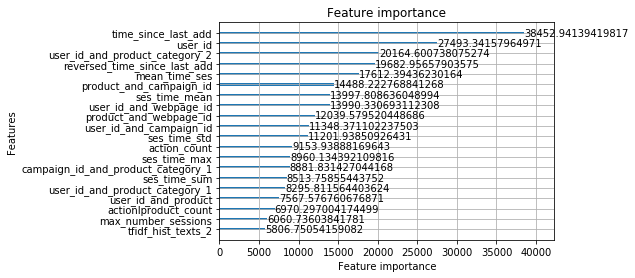

In [85]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')

In [86]:
test_preds = pd.DataFrame({})
for f in os.listdir(ModelFolder+'/test'):
    temp = pd.read_csv(ModelFolder+'/test/'+f)
    temp.columns = [f]
    test_preds = pd.concat([test_preds, temp], axis=1)

In [87]:
test_preds.head()

,nfold0.csv,nfold1.csv,nfold2.csv,nfold3.csv,nfold4.csv,nfold5.csv,nfold6.csv,nfold7.csv,nfold8.csv,nfold9.csv
0,0.105192,0.100939,0.101476,0.100957,0.097698,0.103198,0.099371,0.092635,0.101964,0.099124
1,0.031917,0.032275,0.032701,0.032177,0.034859,0.033357,0.038325,0.034842,0.030663,0.026720
2,0.028589,0.029165,0.029297,0.030519,0.034202,0.031740,0.036236,0.034311,0.029044,0.024775
3,0.051461,0.049831,0.049095,0.051112,0.044414,0.046187,0.046050,0.048286,0.044096,0.056263
4,0.072976,0.075353,0.071350,0.071692,0.070144,0.069963,0.064078,0.081827,0.061404,0.063196


In [88]:
from scipy.stats.mstats import gmean

In [89]:
ssub['is_click'] = test_preds.rank().mean(axis=1) #test_preds.mean(axis=1)
ssub.to_csv(ModelFolder+model_name+'_submit.csv',index=False)

In [90]:
ssub.head()

,session_id,is_click
0,411705,114895.4
1,208263,23470.9
2,239450,20234.3
3,547761,51044.1
4,574275,85334.0


In [ ]:
# 

In [ ]:
def permutation_feature_selection(model, X_val, y_val, pred_proba=False, rep=3, max_delta_score=0.0):
    from sklearn.metrics import roc_auc_score

    # to do: predict_proba from Booster

    """""
    Perform permutation feature importance calculation for trained LightGBM model. 
    Scorer - ROC AUC. 
    The lower score with permuted feature - the more important feature is. 
    
    Parameters
    ----------
    model : lightGBM.Booster
        Trained model to perform feature importance calculation 
        
    X_val : pandas.DataFrame
        Validation dataset
            
    y_val : pandas.Series 
        Targets for validation dataset
       
    rep : integer (default = 3)
        Number of permutations. More permutations lead to more robust results, but requires more calculation time.
        It is recommended to use values in the range [3; 10].
        
    min_delta_score : float (default = 0.0)
        Minimum delta ins score to keep feature 
        It is recommended to use values in the range [-0.0001; 0].
        
    Output
    ----------
    selected_features : list
        Important features 
        
    importance_df : pandas.DataFrame 
        Records of calculations 
    """""

    print('Permutation feature importance is calculating...')

    columns = []
    scores = []
    stds = []
    score_max = []
    score_min = []

    # calculate the score of model with no permuted features, this is our baseline
    y_hat_nopert = model.predict(X_val)
    score_init = roc_auc_score(y_val, y_hat_nopert)

    for cc in tqdm(X_val.columns):
        scores_cc = []
        for seed in range(rep):
            # shuffle single column of dataset
            data_temp = X_val.copy()
            data_temp[cc] = data_temp[cc].sample(n=X_val.shape[0], random_state=seed).reset_index(drop=True)

            # make prediction on 'shuffled' dataset and score it
            y_hat = model.predict(data_temp)
            score = roc_auc_score(y_val, y_hat)
            scores_cc.append(score)

        columns.append(cc)
        scores.append(np.mean(scores_cc) - score_init)
        stds.append(np.std(scores_cc))
        score_max.append(np.max(scores_cc) - score_init)
        score_min.append(np.min(scores_cc) - score_init)

    importance_df = pd.DataFrame({'delta_score_mean': scores,
                                  'delta_score_std': stds,
                                  'delta_score_max': score_max,
                                  'delta_score_min': score_min,
                                  'feature': columns
                                  })
    importance_df = importance_df.sort_values(by='delta_score_mean')
    selected_features = list(importance_df.loc[importance_df['delta_score_mean'] <= max_delta_score, 'feature'])

    print('Permutation feature importance calculation is done. Overall number of features: ', importance_df.shape[0],
          'Number of selected features:', len(selected_features))

    return selected_features, importance_df

In [ ]:
selected_features, importance_df = permutation_feature_selection(model, X_val_temp, y_val_temp, rep=6)

In [ ]:
np.sum(importance_df[importance_df['delta_score_mean']>0]['delta_score_mean'])

In [ ]:
selected_features

In [ ]:
importance_df